<a href="https://colab.research.google.com/github/Raahim58/PRNet_MaanzAI/blob/main/PRNet_replicate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PRNet: Progressive Resolution based Network for Radiograph based disease classification

- Reproduce the architecture and results from the PRNet paper
  - paper link: file:///Users/Raahim/Documents/LUMS/Sophomore/Sophomore%20Summer%20semester%202025/research/maanz-ai%20internship/PRNet_Progressive_Resolution_based_Network_for_Radiograph_based_disease_classification.pdf (attach official link or github link)
  - dataset: https://cxr-covid19.grand-challenge.org/
  - backup dataset: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database

# 0. Starter Code

In [ ]:
import os, random, time
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import time
from tqdm.auto import tqdm
import shutil

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms, utils
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
# fix random seeds for reproducibility
def set_global_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_global_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## 1. Readying code: Dataset, transforms and visualizations

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/covid19-radiography-database


In [5]:
import os

# List folders/files inside the dataset root directory
for root, dirs, files in os.walk(path):
    print(f"\nInspecting folder: {root}")
    print("Subdirectories:", dirs)
    print("Files:", files)
    # break  # Only list top-level directories (remove this to go deeper)


Inspecting folder: /kaggle/input/covid19-radiography-database
Subdirectories: ['COVID-19_Radiography_Dataset']
Files: []

Inspecting folder: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset
Subdirectories: ['Normal', 'Lung_Opacity', 'Viral Pneumonia', 'COVID']
Files: ['Lung_Opacity.metadata.xlsx', 'Normal.metadata.xlsx', 'README.md.txt', 'COVID.metadata.xlsx', 'Viral Pneumonia.metadata.xlsx']

Inspecting folder: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal
Subdirectories: ['images', 'masks']
Files: []

Inspecting folder: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images
Subdirectories: []
Files: ['Normal-859.png', 'Normal-158.png', 'Normal-10121.png', 'Normal-1811.png', 'Normal-97.png', 'Normal-1088.png', 'Normal-5663.png', 'Normal-6328.png', 'Normal-8410.png', 'Normal-5641.png', 'Normal-4852.png', 'Normal-9518.png', 'Normal-6443.png', 'Normal-6391.png', 'Normal-8481.png', 'Normal-3896.png', '

In [7]:
# set the base paths
base_dataset_path = os.path.join(path, "COVID-19_Radiography_Dataset")
output_base = "data"
splits = ['train', 'val', 'test']
split_ratio = [0.8, 0.1, 0.1]  # 70% train, 15% val, 15% test
classes = ['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity']

# create output directories
for split in splits:
    for class_name in classes:
        os.makedirs(os.path.join(output_base, split, class_name), exist_ok=True)

# function to split and copy images
for class_name in classes:
    source_dir = os.path.join(base_dataset_path, class_name, "images")
    all_images = os.listdir(source_dir)
    random.shuffle(all_images)
    n_total = len(all_images)
    n_train = int(split_ratio[0] * n_total)
    n_val = int(split_ratio[1] * n_total)
    train_images = all_images[:n_train]
    val_images = all_images[n_train:n_train + n_val]
    test_images = all_images[n_train + n_val:]

    def copy_images(image_list, split_name):
        for image in tqdm(image_list, desc=f"{split_name} - {class_name}"):
            src = os.path.join(source_dir, image)
            dst = os.path.join(output_base, split_name, class_name, image)
            shutil.copyfile(src, dst)
    copy_images(train_images, "train")
    copy_images(val_images, "val")
    copy_images(test_images, "test")

train - COVID:   0%|          | 0/2892 [00:00<?, ?it/s]

val - COVID:   0%|          | 0/361 [00:00<?, ?it/s]

test - COVID:   0%|          | 0/363 [00:00<?, ?it/s]

train - Normal:   0%|          | 0/8153 [00:00<?, ?it/s]

val - Normal:   0%|          | 0/1019 [00:00<?, ?it/s]

test - Normal:   0%|          | 0/1020 [00:00<?, ?it/s]

train - Viral Pneumonia:   0%|          | 0/1076 [00:00<?, ?it/s]

val - Viral Pneumonia:   0%|          | 0/134 [00:00<?, ?it/s]

test - Viral Pneumonia:   0%|          | 0/135 [00:00<?, ?it/s]

train - Lung_Opacity:   0%|          | 0/4809 [00:00<?, ?it/s]

val - Lung_Opacity:   0%|          | 0/601 [00:00<?, ?it/s]

test - Lung_Opacity:   0%|          | 0/602 [00:00<?, ?it/s]

In [14]:
# loading dataset
# class ChestXRayDataset(Dataset):
#   def __init__(self, root_dir: str, class_names: list, transform=None):
#     self.image_paths = []
#     self.labels = []
#     for idx, class_name in enumerate(class_names):
#       class_dir = os.path.join(root_dir, class_name)
#       files = glob(class_dir) # get all images of each class
#       self.image_paths += files
#       self.labels += [idx] * len(files) # appends label for each class image found
#     self.transform = transform

#   def __len__(self):
#     return len(self.image_paths)

#   def __getitem__(self, index):
#     image_path = self.image_paths[index]
#     image = Image.open(image_path).convert("RGB")
#     label = self.labels[index]
#     if self.transform:
#       image = self.transform(image)
#     return image, label
class ChestXRayDataset(Dataset):
    def __init__(self, data_dir, class_names, transform=None):
        # self.data_dir = data_dir
        # self.class_names = class_names
        # self.transform = transform
        # self.image_paths = []
        # self.labels = []
        # for class_name in class_names:
        #     class_dir = os.path.join(data_dir, class_name)
        #     for fname in os.listdir(class_dir):
        #         fpath = os.path.join(class_dir, fname)
        #         if os.path.isfile(fpath) and fname.lower().endswith(('.png', '.jpg', '.jpeg')):
        #             self.image_paths.append((fpath, class_name))
        #             self.labels.append()
        self.image_paths = []
        self.labels = []
        for idx, class_name in enumerate(class_names):
            class_dir = os.path.join(data_dir, class_name)
            for fname in os.listdir(class_dir):
                fpath = os.path.join(class_dir, fname)
                if os.path.isfile(fpath) and fname.lower().endswith(('.png','jpg','jpeg')):
                    self.image_paths.append(fpath)
                    self.labels.append(idx)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        image = np.array(image) # PIL → H×W×C numpy array
        if self.transform:
            augmented = self.transform(image=image) # must pass as keyword
            image = augmented['image'] # grab the transformed tensor

        return image, label

In [15]:
# transformations
def get_train_augmentations(image_size: int):
    return A.Compose([
        A.Resize(image_size, image_size),
        A.HorizontalFlip(p=0.5),
        # A.RandomBrightness(limit=0.2, p=0.3), # changes image brightness to mimic lighting variation # search for right import
        # A.RandomContrast(limit=0.2, p=0.3), # modifies contrast to handle visual differences
        A.Blur(blur_limit=3, p=0.2), # general softening of the image
        A.MedianBlur(blur_limit=3, p=0.2), # removes noise while keeping edges sharp
        A.GaussianBlur(blur_limit=(3,5), p=0.2), # natural smooth blur like out-of-focus camera
        A.MotionBlur(blur_limit=5, p=0.2), # simulates camera shake or patient movement
        A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=0.3), # lens-like warping of image
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.3), # distorts image with grid pattern
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3), # adjusts tint, saturation, brightness
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.5), # shifts, zooms, rotates image slightly
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

def get_val_augmentations(image_size: int):
    return A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
        ToTensorV2(),
    ])


In [16]:
# visualize images
def imshow(img_tensor, mean, std):
    """
    img_tensor: C×H×W torch Tensor, normalized
    mean, std: sequences of length C
    returns: H×W×C numpy array in [0,1]
    """
    # move to C×H×W numpy
    img = img_tensor.cpu().numpy()
    # unnormalize per channel
    for c in range(img.shape[0]):
        img[c] = img[c] * std[c] + mean[c]
    # transpose to H×W×C
    img = np.transpose(img, (1,2,0))
    # clip to valid range
    return np.clip(img, 0, 1)

def show_batch(dataset, class_names, num_samples=16):
    loader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
    images, labels = next(iter(loader))

    # constants – must match Normalize()
    mean = (0.485, 0.456, 0.406)
    std  = (0.229, 0.224, 0.225)

    n = int(num_samples**0.5)  # for a 4×4 grid if num_samples=16
    fig, axes = plt.subplots(n, n, figsize=(n*4, n*4))

    for ax, img_t, lab in zip(axes.flatten(), images, labels):
        img = imshow(img_t, mean, std)
        ax.imshow(img)
        ax.set_title(class_names[lab], fontsize=12)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# def show_batch(dataset, class_names, num_samples=16):
#     loader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
#     images, labels = next(iter(loader))
#     # 4×4 grid
#     n = int(num_samples**0.5)
#     fig, axes = plt.subplots(n, n, figsize=(n*4, n*4))
#     for ax, img, lab in zip(axes.flatten(), images, labels):
#         # img is C×H×W tensor in [0,1]; move to H×W×C:
#         ax.imshow(img.permute(1, 2, 0).cpu().numpy())
#         ax.set_title(class_names[lab], fontsize=12)
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()

/tmp/ipython-input-15-1779862192.py:12: UserWarning: Argument(s) 'shift_limit' are not valid for transform OpticalDistortion
  A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=0.3), # lens-like warping of image


Raw images: 


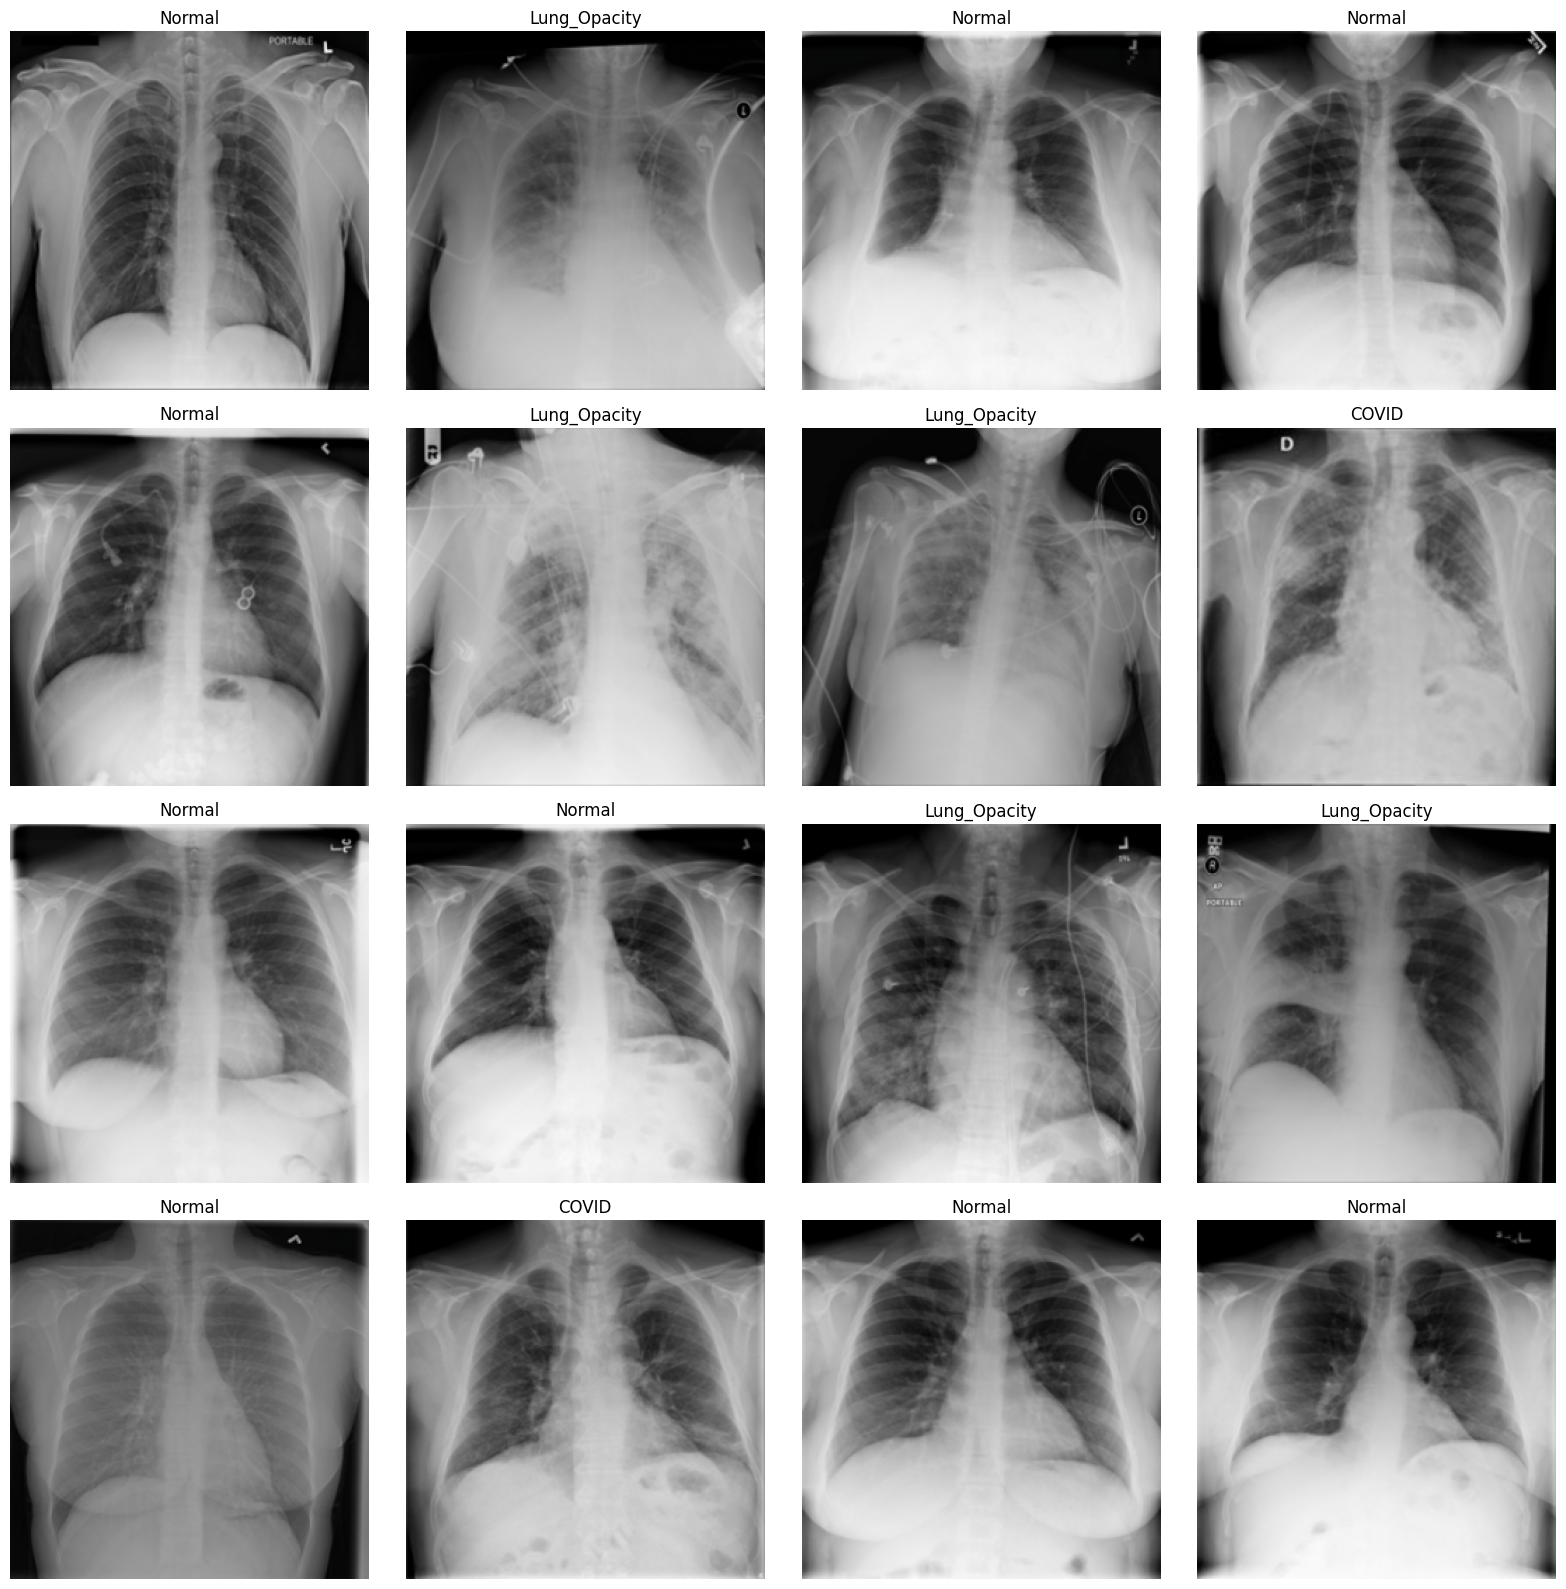

In [17]:
# usage
train_dir = "/content/data/train"
class_names = sorted(os.listdir(train_dir))
raw_dataset = ChestXRayDataset(train_dir, class_names, transform=get_val_augmentations(256))
aug_dataset = ChestXRayDataset(train_dir, class_names, transform=get_train_augmentations(256))
print("Raw images: ")
show_batch(raw_dataset, class_names)

Augmented images: 


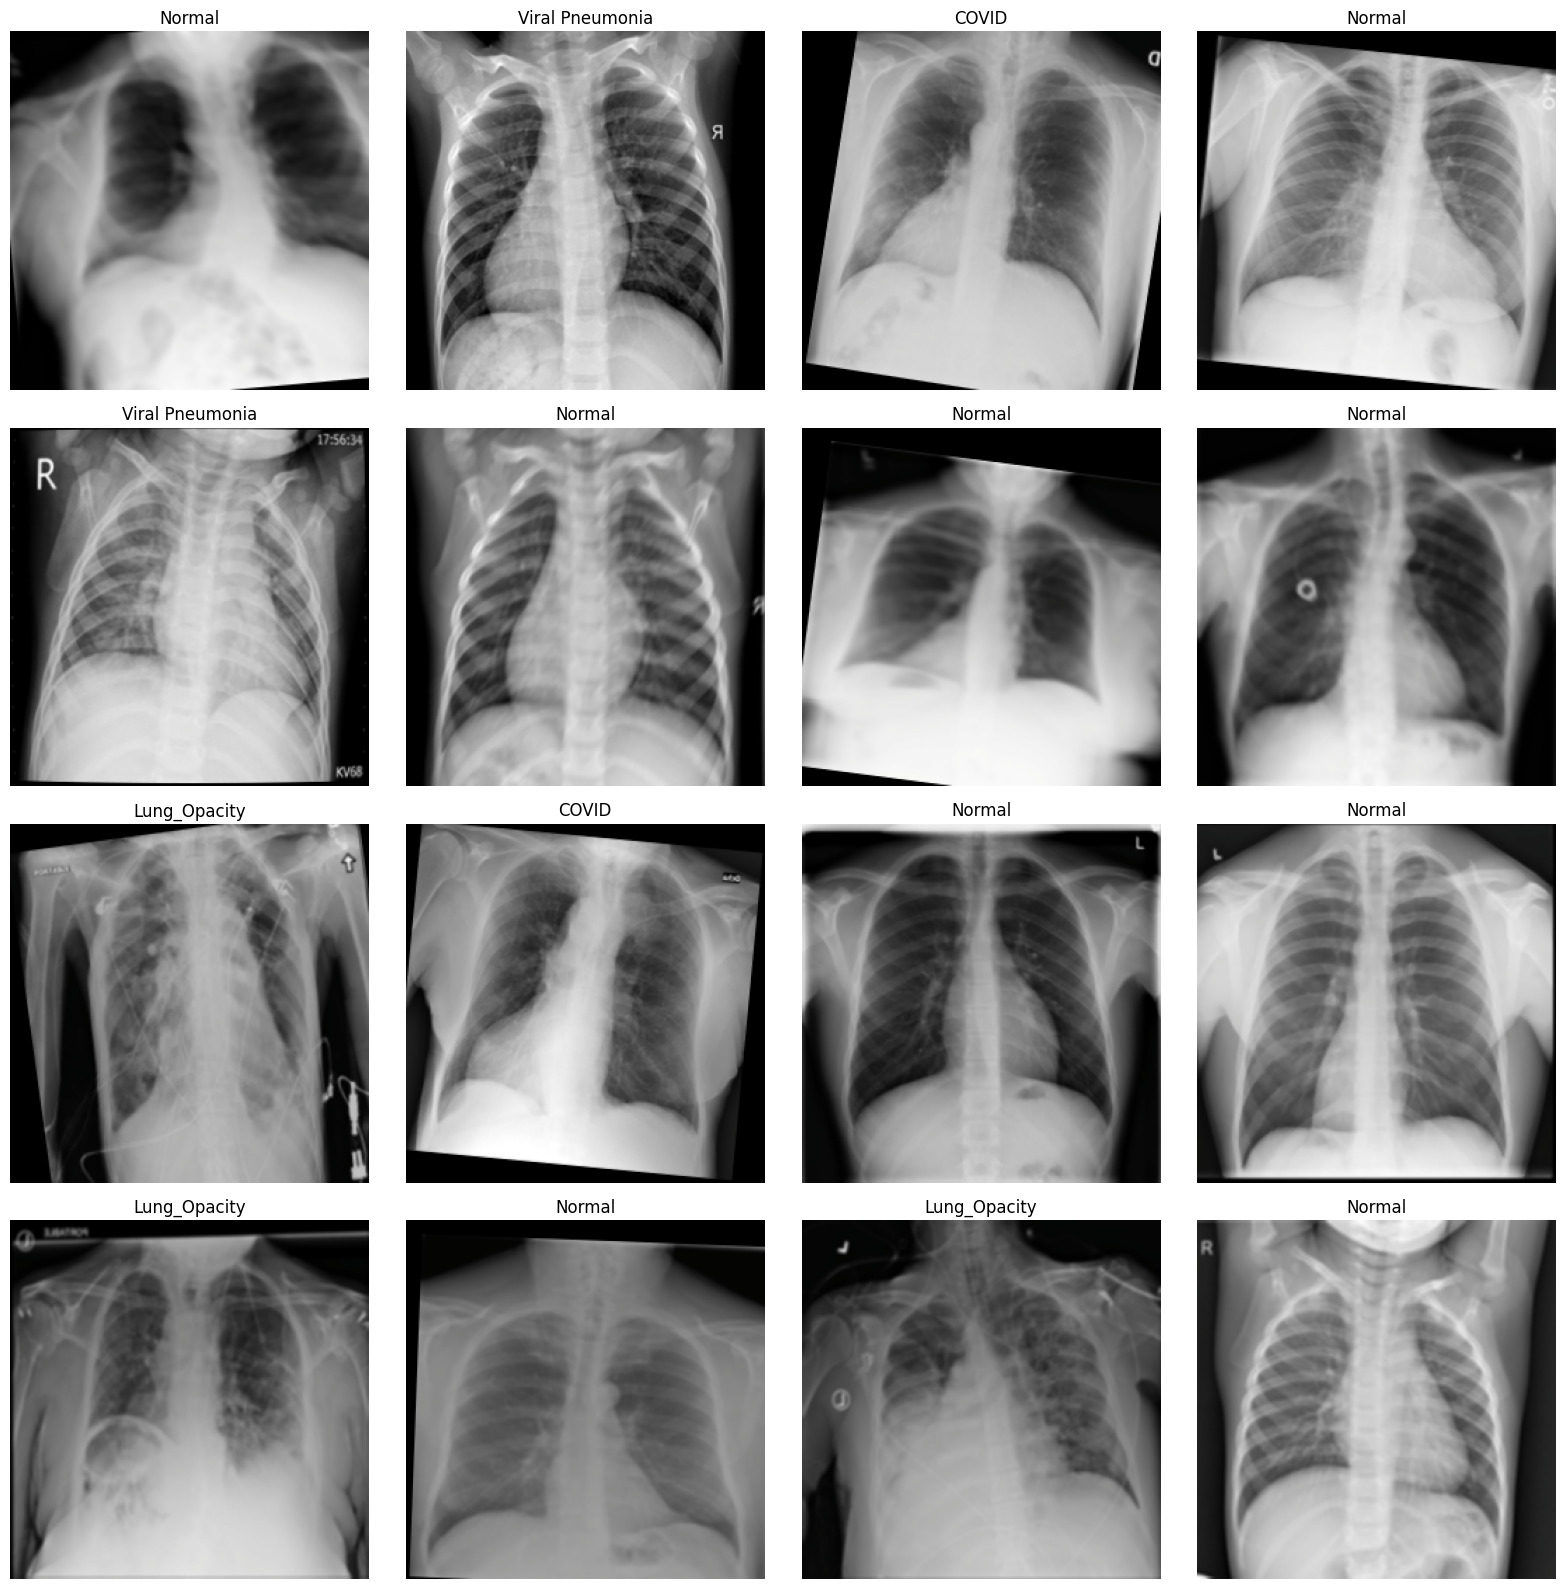

In [18]:
print("Augmented images: ")
show_batch(aug_dataset, class_names)

## 2. Model definitions

In [ ]:
# class PRNetEffNetB5(nn.Module):
#   def __init__(self, num_classes: int):
#     super().__init__()
#     self.backbone = timm.create_model('efficientnet_b5', pretrained=True, features_only=True) # defining own classification head
#     num_channels = self.backbone.feature_info[-1]["num_chs"] # get the most abstract feature_map from the the backbone layer
#     self.global_pool = nn.AdapativeAvgPool2d(1)
#     self.classifier_dropout = nn.Dropout(p=0.5)
#     self.classifier = nn.Linear(num_channels, num_classes)

#   def forward(self, x):
#     features = self.backbone(x)[-1]
#     pooled = self.global_pool(features).flatten(1) # takes output of [B, C, H, W] and coverts it to [B, C, 1, 1] or [B, C]
#     dropped = self.classifier_dropout(pooled)
#     logits = self.classifier(dropped)
#     return logits

In [ ]:
# class VisionTransformerStub(nn.Module):
#     def __init__(self, num_classes: int):
#         super().__init__()
#         self.vit = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=num_classes)
#     def forward(self, x):
#         return self.vit(x)

## 3. Bias-adjustable Softmax

In [24]:
def bias_softmax(logits, exps):
    probs = torch.softmax(logits, dim=-1)
    adj = probs ** torch.tensor(exps, device=probs.device)
    return adj / adj.sum(-1, keepdim=True)

def search_biased_exponents(val_loader, model, exp_range=(0.0,5.0), step=0.1):
    model.eval()
    all_logits = []
    all_labels = []
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs = imgs.to(device)
            all_logits.append(model(imgs).cpu())
            all_labels.append(torch.tensor(lbls))
    all_logits = torch.cat(all_logits)
    all_labels = torch.cat(all_labels)
    best = [1.0]*all_logits.size(1)
    for c in range(all_logits.size(1)):
        best_acc,best_p=0,1.0
        for p in np.arange(exp_range[0], exp_range[1]+1e-9, step):
            exps = best.copy()
            exps[c] = p
            preds = bias_softmax(all_logits, exps).argmax(1)
            acc = (preds==all_labels).float().mean().item()
            if acc>best_acc: best_acc,best_p=acc,p
        best[c]=best_p
    return best

## 4. Training + Validation

Dropout (in your model):

Randomly sets some neurons to zero during training
Prevents neurons from becoming too dependent on each other
Applied to activations/features

Weight Decay (in optimizer):

Penalizes large weight values directly
Keeps weights small to prevent overfitting
Applied to the actual model parameters

Why Use Both?
They target different aspects of overfitting:
Dropout prevents co-adaptation - stops neurons from memorizing specific patterns together
Weight Decay prevents parameter explosion - stops individual weights from becoming too large

In [25]:
def create_warmup_cosine_scheduler(optimizer, total_epochs, warmup_epochs=3, min_lr=1e-7):
    """
    Returns a SequentialLR that:
     - linearly warms lr from 0→initial over `warmup_epochs`
     - then cosine-anneals from initial→`min_lr` over remaining epochs
     - LR = min_lr + 0.5 * (max_lr - min_lr) * (1 + cos(π * current_step / T_max))
    """
    # warmup: 0 → 1×LR
    warmup = LinearLR(
        optimizer,
        start_factor=0.0,
        end_factor=1.0,
        total_iters=warmup_epochs
    )
    # cosine: 1×LR → min_lr
    cosine = CosineAnnealingLR(
        optimizer,
        T_max=max(total_epochs - warmup_epochs, 1), # ensures atleast T_max = 1 to avoid division by 0 in cosin formular
        eta_min=min_lr
    )
    # join them at warmup_epochs
    scheduler = SequentialLR(
        optimizer,
        schedulers=[warmup, cosine],
        milestones=[warmup_epochs]
    )
    return scheduler

In [ ]:
def run_configuration(
    backbone_name: str,
    image_size: int,
    use_progressive: bool,
    use_bas: bool,
    data_dir: str = "/content/data",
    total_epochs: int = 20,
    batch_size: int = 16,
    base_lr: float = 1e-4,
    weight_decay: float = 1e-4,
    early_stopping_patience: int = 5 ) -> dict:

    # basic setup stuff
    class_names = sorted(os.listdir(f"{data_dir}/train"))
    num_classes = len(class_names)
    model       = create_effnet_backbone(backbone_name, num_classes)
    criterion   = nn.CrossEntropyLoss()
    optimizer   = optim.AdamW(model.parameters(), lr=base_lr, weight_decay=weight_decay)
    scheduler   = create_warmup_cosine_scheduler(optimizer, total_epochs)

    # figure out what image sizes we're gonna use
    # if progressive: start small and work our way up like the paper says
    # if not: just use the final size the whole time
    stages = [image_size] if not use_progressive else [256, 380, 460, 512, image_size]
    epochs_per_stage = total_epochs // len(stages)
    prev_ckpt = None
    total_train_time = total_val_time = 0.0

    # keep track of the absolute best accuracies we've seen across ALL stages
    best_overall_train_acc = 0.0
    best_overall_val_acc   = 0.0

    # go through each image size stage
    for stage_idx, sz in enumerate(stages, 1):
        print(f"starting stage {stage_idx}/{len(stages)} with image size {sz}x{sz}")

        # if we have a checkpoint from previous stage, load it up
        if prev_ckpt:
            model.load_state_dict(torch.load(prev_ckpt))
            print(f"loaded weights from {prev_ckpt}")

        # create data loaders for this specific image size
        train_loader = DataLoader(
            ChestXrayDataset(f"{data_dir}/train", class_names, transform=get_train_transform(sz)),
            batch_size=batch_size, shuffle=True, num_workers=4
        )
        val_loader = DataLoader(
            ChestXrayDataset(f"{data_dir}/val",   class_names, transform=get_val_transform(sz)),
            batch_size=batch_size, shuffle=False, num_workers=4
        )

        # early stopping stuff for this stage
        epochs_no_improve = 0
        best_stage_val_acc = 0.0

        # train for the allocated epochs at this resolution
        for epoch in range(1, epochs_per_stage+1):
            # TRAINING PHASE
            model.train()
            t0 = time.time()
            correct_tr = tot_tr = 0

            train_bar = tqdm(train_loader, desc=f"stage {stage_idx} @{sz}px - training epoch {epoch}", leave=False)
            for imgs, lbls in train_bar:
                imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)

                # forward pass
                logits = model(imgs)
                loss   = criterion(logits, lbls)

                # backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # track accuracy for this batch
                preds = logits.argmax(1)
                correct_tr += (preds==lbls).sum().item()
                tot_tr     += lbls.size(0)

                # update progress bar with current accuracy
                current_acc = correct_tr / tot_tr
                train_bar.set_postfix({'acc': f'{current_acc:.3f}'})

            epoch_train_time = time.time() - t0
            total_train_time += epoch_train_time

            # calculate final training accuracy for this epoch
            train_acc = correct_tr / tot_tr
